In [1]:
import pandas as pd
# pandas show all columns of table instead of restricted#
pd.set_option('display.max_columns', None)
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import math

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig
# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))



# ---------------CUSTOM -------------------------------------

def get_sensor_columns(df):
    sensor = df.filter(like='sensor.', axis=1).columns.copy()
    sensor = sensor.tolist()
    df = df[sensor]
    return df

In [2]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=40) 
track_df.drop_duplicates(subset=['geometry', 'Engine Load.value', 'Calculated MAF.value',
       'Speed.value', 'CO2.value', 'Intake Pressure.value', 'Rpm.value',
       'Intake Temperature.value', 'Consumption (GPS-based).value',
       'GPS Altitude.value', 'Throttle Position.value', 'GPS Bearing.value',
       'Consumption.value', 'GPS Accuracy.value',
       'CO2 Emission (GPS-based).value', 'GPS Speed.value', 
       'track.length', 'track.begin', 'track.end', 'sensor.type',
       'sensor.engineDisplacement', 'sensor.model', 'sensor.id',
       'sensor.fuelType', 'sensor.constructionYear', 'sensor.manufacturer',
       'track.appVersion', 'track.touVersion', 'GPS HDOP.value',
       'GPS PDOP.value', 'GPS VDOP.value'], inplace=True, keep='last')

Understand the datatypes

In [3]:
track_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9886 entries, 0 to 187
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              9886 non-null   object  
 1   time                            9886 non-null   object  
 2   geometry                        9886 non-null   geometry
 3   Engine Load.value               9065 non-null   float64 
 4   Engine Load.unit                9065 non-null   object  
 5   Calculated MAF.value            7127 non-null   float64 
 6   Calculated MAF.unit             7127 non-null   object  
 7   Speed.value                     9879 non-null   float64 
 8   Speed.unit                      9879 non-null   object  
 9   CO2.value                       7839 non-null   float64 
 10  CO2.unit                        7839 non-null   object  
 11  Intake Pressure.value           8380 non-null   float64 
 12  Intake Pressu

We only want to have objects here, therefore we select only variables which are of type object

In [4]:
objects = track_df.select_dtypes(['object'])

In [5]:
objects

,id,time,Engine Load.unit,Calculated MAF.unit,Speed.unit,CO2.unit,Intake Pressure.unit,Rpm.unit,Intake Temperature.unit,Consumption (GPS-based).unit,GPS Altitude.unit,Throttle Position.unit,GPS Bearing.unit,Consumption.unit,GPS Accuracy.unit,CO2 Emission (GPS-based).unit,GPS Speed.unit,track.id,track.begin,track.end,sensor.type,sensor.model,sensor.id,sensor.fuelType,sensor.manufacturer,track.appVersion,track.touVersion,GPS HDOP.unit,GPS PDOP.unit,GPS VDOP.unit,MAF.unit,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.unit
0,5f0ef89c00375c5a2641ef86,2020-07-15T12:37:03,%,g/s,km/h,kg/h,kPa,u/min,c,l/h,m,%,deg,l/h,%,kg/h,km/h,5f0ef89c00375c5a2641ef84,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5f0ef89c00375c5a2641ef88,2020-07-15T12:37:09,%,g/s,km/h,kg/h,kPa,u/min,c,l/h,m,%,deg,l/h,%,kg/h,km/h,5f0ef89c00375c5a2641ef84,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5f0ef89c00375c5a2641ef89,2020-07-15T12:37:14,%,g/s,km/h,kg/h,kPa,u/min,c,l/h,m,%,deg,l/h,%,kg/h,km/h,5f0ef89c00375c5a2641ef84,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5f0ef89c00375c5a2641ef8a,2020-07-15T12:37:19,%,g/s,km/h,kg/h,kPa,u/min,c,l/h,m,%,deg,l/h,%,kg/h,km/h,5f0ef89c00375c5a2641ef84,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5f0ef89c00375c5a2641ef8b,2020-07-15T12:37:24,%,g/s,km/h,kg/h,kPa,u/min,c,l/h,m,%,deg,l/h,%,kg/h,km/h,5f0ef89c00375c5a2641ef84,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,57c7cdfae4b0f05fc1c868ed,2016-08-10T15:52:10,%,NaN,km/h,NaN,kPa,u/min,c,NaN,m,%,deg,NaN,%,NaN,km/h,57c7cdfae4b0f05fc1c86833,2016-08-10T15:36:49Z,2016-08-10T15:52:30Z,car,passat,5796666de4b086b281bfc0be,diesel,VW,NaN,NaN,precision,precision,precision,l/s,ratio,V
184,57c7cdfae4b0f05fc1c868ee,2016-08-10T15:52:15,%,NaN,km/h,NaN,kPa,u/min,c,NaN,m,%,deg,NaN,%,NaN,km/h,57c7cdfae4b0f05fc1c86833,2016-08-10T15:36:49Z,2016-08-10T15:52:30Z,car,passat,5796666de4b086b281bfc0be,diesel,VW,NaN,NaN,precision,precision,precision,l/s,ratio,V
185,57c7cdfae4b0f05fc1c868ef,2016-08-10T15:52:20,%,NaN,km/h,NaN,kPa,u/min,c,NaN,m,%,deg,NaN,%,NaN,km/h,57c7cdfae4b0f05fc1c86833,2016-08-10T15:36:49Z,2016-08-10T15:52:30Z,car,passat,5796666de4b086b281bfc0be,diesel,VW,NaN,NaN,precision,precision,precision,l/s,ratio,V
186,57c7cdfae4b0f05fc1c868f0,2016-08-10T15:52:25,%,NaN,km/h,NaN,kPa,u/min,c,NaN,m,%,deg,NaN,%,NaN,km/h,57c7cdfae4b0f05fc1c86833,2016-08-10T15:36:49Z,2016-08-10T15:52:30Z,car,passat,5796666de4b086b281bfc0be,diesel,VW,NaN,NaN,precision,precision,precision,l/s,ratio,V


For the moment we are mainly interested in categorical variables which refer to the attributes of the sensor.

In [6]:
sensorAttributes = get_sensor_columns(objects)
sensorAttributes

,sensor.type,sensor.model,sensor.id,sensor.fuelType,sensor.manufacturer
0,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz
1,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz
2,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz
3,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz
4,car,A 170,559e22c2e4b07207d8977998,gasoline,Mercedes Benz
...,...,...,...,...,...
183,car,passat,5796666de4b086b281bfc0be,diesel,VW
184,car,passat,5796666de4b086b281bfc0be,diesel,VW
185,car,passat,5796666de4b086b281bfc0be,diesel,VW
186,car,passat,5796666de4b086b281bfc0be,diesel,VW


Inspect the categroies per variable:

In [7]:
for column in sensorAttributes:
    print(sensorAttributes[column].unique())

['car']
['A 170' 'V40' 'passat']
['559e22c2e4b07207d8977998' '564b916be4b0a3a81b856f28'
 '5796666de4b086b281bfc0be']
['gasoline' 'diesel']
['Mercedes Benz' 'Volvo' 'VW']


Inspect distribution of each categorical variable:

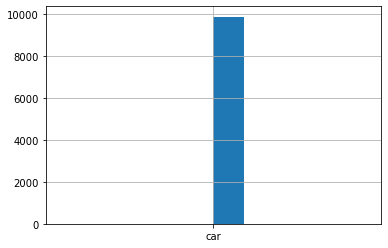

In [8]:
sensorAttributes['sensor.type'].hist()

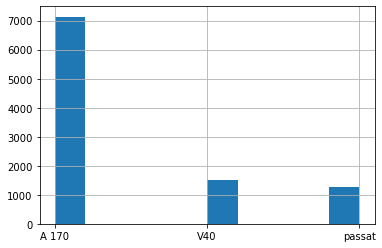

In [9]:
sensorAttributes['sensor.model'].hist()

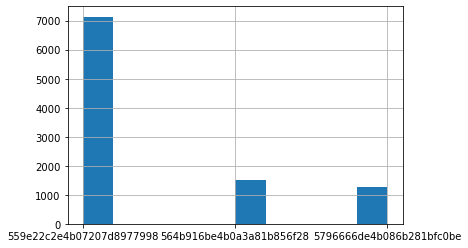

In [10]:
sensorAttributes['sensor.id'].hist()

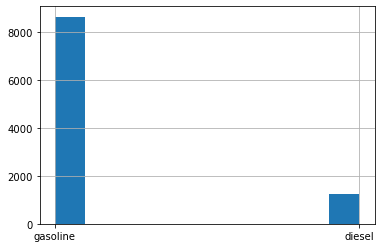

In [11]:
sensorAttributes['sensor.fuelType'].hist()

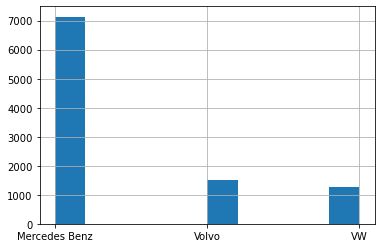

In [12]:
sensorAttributes['sensor.manufacturer'].hist()